# Comparison of Modeled and Observed Atmospheric DMS and CHBr3 

### Prepare Workspace

In [80]:
import numpy as np
import xarray as xr
import pandas as pd 
import datetime 

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits import mplot3d
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline
%config inlinebackend.figure_format='retina'

### Define a few functions

In [81]:
# make functions we'll use 
# find index of value closest to desired value 
def find_nearest(desired, variable):
    diff = ([])
    for ll in variable:
        dd = np.absolute(desired - ll)
        diff.append(dd)
    ind = diff.index(min(diff))
    val = np.float(variable[ind])
    return ind

# convert pressure in hpa to height in km
# p = p0*exp(-z/H)
H = 10*1000 # km to m  
p0 = 100000 # Pa 
def hpa_to_km(hpa_in):
    m = np.log(hpa_in/p0)*-H
    km_out = m/1000
    return km_out

# and km to hpa 
def km_to_hpa(km_in):
    m = km_in*1000
    pa = p0*np.exp(-m/H)
    hpa_out = pa/100
    return hpa_out

### Load in Aircraft Data from the CONTRAST Field Campaign

In [82]:
! wget -O contrast_file 'https://docs.google.com/uc?export=download&id=1xVarpVV6Su5ophCqOpG14D4lHrF1xHBa'

/bin/sh: wget: command not found


In [83]:
# read in the file using xarray 
toga = xr.open_dataset('contrast_file')

# make a smaller more workable data set (we dont need all those variables)
toga = toga[['Time','GGLAT', 'GGLON', 'GGALT', 'DMS', 'Bromoform', 'CFC11']]
toga

# handle fill values 
dms_fill_ulod = np.where(toga.DMS == -888)
dms_fill_nosample = np.where(toga.DMS == -9999)
toga.DMS[dms_fill_ulod] = np.nan
toga.DMS[dms_fill_nosample] = np.nan

bromo_fill_ulod = np.where(toga.Bromoform == -888)
bromo_fill_nosample = np.where(toga.Bromoform == -9999)
toga.Bromoform[bromo_fill_ulod] = np.nan
toga.Bromoform[bromo_fill_nosample] = np.nan

toga

<xarray.Dataset>
Dimensions:    (Time: 196)
Coordinates:
  * Time       (Time) datetime64[ns] 2014-02-12T23:59:25 ... 2014-02-13T06:29:25
Data variables:
    GGLAT      (Time) float32 ...
    GGLON      (Time) float32 ...
    GGALT      (Time) float32 ...
    DMS        (Time) float32 5.97 0.78 nan nan nan nan ... 7.58 nan nan nan nan
    Bromoform  (Time) float32 0.678 0.539 0.449 0.398 0.32 ... nan nan nan nan
    CFC11      (Time) float32 ...
Attributes:
    Institution:                     NCAR Atmospheric Chemistry Observations ...
    Address:                         P.O. Box 3000, Boulder, CO 80307-3000
    Phone:                           (303) 497-8194
    Author:                          Shawn Honomichl
    Author_Email:                    shawnh@ucar.edu
    Nomenclature_compliance_note:    Spaces removed from variable names when ...
    Merged_NetCDF_Creation_Date:     Wed Aug 24 21:12:41 2016
    Project_Name:                    CONTRAST
    Aircraft_Type:                 

### Load in CAMchem model data

In [84]:
! wget -O camchem_file 'https://docs.google.com/uc?export=download&id=1XnQLD3iAt6ALa1D8P1GMZTmK1317ZPE8'

/bin/sh: wget: command not found


In [85]:
cam = xr.open_dataset('camchem_file')
# convert units from mol/mol to pptv 
cam = cam[['DMS', 'CHBR3']]*(1e12)
cam

<xarray.Dataset>
Dimensions:  (lat: 32, lev: 56, lon: 25, time: 1)
Coordinates:
  * lat      (lat) float64 0.4712 1.414 2.356 3.298 ... 26.86 27.8 28.74 29.69
  * lon      (lon) float64 130.0 131.2 132.5 133.8 ... 156.2 157.5 158.8 160.0
  * lev      (lev) float64 1.868 2.353 2.948 3.677 ... 947.5 962.5 977.5 992.5
  * time     (time) object 2014-12-01 00:00:00
Data variables:
    DMS      (time, lev, lat, lon) float32 4.1773454e-25 ... 14.167538
    CHBR3    (time, lev, lat, lon) float32 5.949005e-26 ... 1.6521943
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             f.e11.TS1IREFC1SD.f09.f09.ccmi34.Aircraft_2014-2016.cy.001
    title:            UNSET
    logname:          dkin
    host:             r1i4n16
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade2/scratch2/dkin/f.e11.TS1IREFC1SD.f09.f09.ccmi34....
    topography_file:  /glade/p/acd/tilmes/inputdata/topo/USGS-gtopo30_0.9x1.2...

### Figure 1: Study Area and Flight Path

Text(129, 14, 'Phillipines')

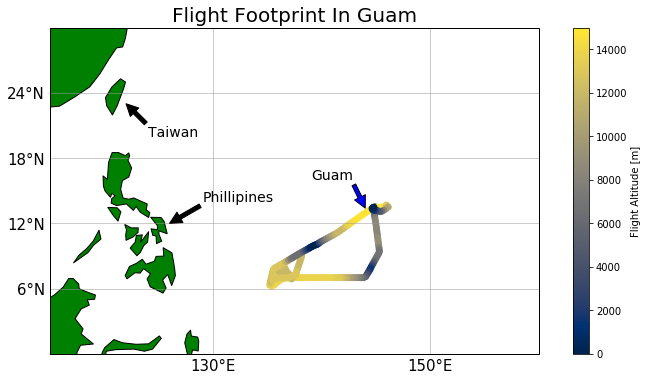

In [86]:
# ------------------------------------------- figure 1 -------------------------------------------
########## plot location 
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

p = ax.scatter(toga.GGLON, toga.GGLAT, c = toga.GGALT, cmap = 'cividis')
ax.set_title('Flight Footprint In Guam', fontsize=20)

# colorbar
m = plt.cm.ScalarMappable(cmap='cividis')
m.set_array(toga.GGALT.values)
m.set_clim(0, 15000)
cbar = plt.colorbar(m)
cbar.set_label('Flight Altitude [m]')

# extents 
latmin = 0 
latmax = 30 
lonmin = 115 
lonmax = 160

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())
#ax.coastlines(resolution='50m', color='k', linewidth=1)
ax.add_feature(cf.LAND, facecolor = 'g', edgecolor = 'k')
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([lonmin, 130, 150, lonmax])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# add guam marker 
ax.annotate('Guam', xy=(144, 13.4),
             xytext=(139, 16), arrowprops={'facecolor': 'b'}, fontsize = 14)

# add some arrows 
ax.annotate('Taiwan', xy=(122, 23),
             xytext=(124, 20), arrowprops={'facecolor': 'k'}, fontsize = 14)
ax.annotate('Phillipines', xy=(126, 12),
             xytext=(129, 14), arrowprops={'facecolor': 'k'}, fontsize = 14)

#### Figure 1
This figure shows the flight path colored by altitude. Vertical extent ranges from the surface to a ceiling of 15 km. The target sampling altitude is the upper troposphere (UT) around 10-14 km. The research flight was based out of Guam. Some notable south-east Asian land masses are identified to orient you to where in the world this data was collected (the tropical western Pacfic). 

### Figure 2: 3D Plots of Flight Bromoform (CHBr3) Data

Text(14, 142, 'Guam')

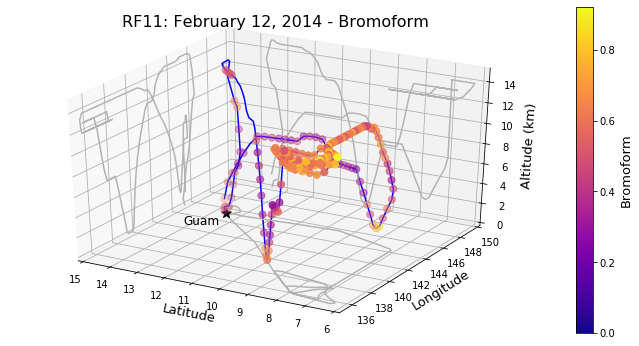

In [87]:
# ------------------------------------------- figure 2 -------------------------------------------
# Bromoform along flight track 
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')

# axis limits
maxx = toga.Bromoform.max()
minn = toga.Bromoform.min()

# plot 
ax.set_title('RF11: February 12, 2014 - Bromoform', fontsize = 16)
a = ax.plot(toga.GGLAT, toga.GGLON, toga.GGALT/1000, c='b')
a = ax.scatter3D(toga.GGLAT, toga.GGLON, toga.GGALT/1000, c=toga.Bromoform, 
                 s = 50, cmap='plasma', vmin = 0, vmax = maxx)
ax.set_xlabel('Latitude', fontsize = 13)
ax.set_xlim([15,6])
ax.set_ylabel('Longitude', fontsize = 13)
ax.set_ylim([135, 150])
ax.set_zlabel('Altitude (km)', fontsize = 13);
ax.set_zlim([0, 15])

# colorbar 
cbar = fig.colorbar(a)
cbar.set_label('Bromoform', fontsize = 13)

# add gray lines 
flat1 = np.zeros_like(toga.GGALT/1000)
ax.plot3D(toga.GGLAT, toga.GGLON, flat1, c=[0.7, 0.7, 0.7])
flat2 = np.full_like(toga.GGLAT, 15)
ax.plot3D(flat2, toga.GGLON, toga.GGALT/1000, c=[0.7, 0.7, 0.7])
flat3 = np.full_like(toga.GGLON, 150)
ax.plot(toga.GGLAT, flat3, toga.GGALT/1000, c=[0.7, 0.7, 0.7])

# add guam pointer 
ax.scatter(13.4, 144.8, marker = '*', color = 'k', s = 100)
ax.text(14, 142, 0, s='Guam', fontsize=12)

#### Figure 2
This 3D plot shows the distribution of bromoform along the flight track in space. The highest values are near the surface (the source of this chemical) and in the UT. This distribution is indicative of convective outflow, a process by which near-surface trace gases are rapidly transported upwards into the UT. There are low concentrations in the middle atmosphere (3 - 7 km) and at the very highest samples (> 12 km). 

### Figure 3: 3D Plots of Flight DMS Data

Text(14, 142, 'Guam')

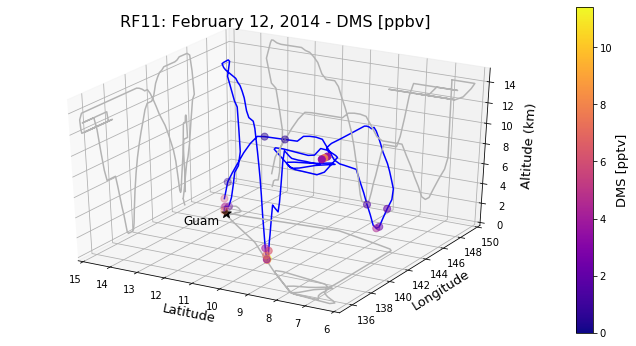

In [88]:
# ------------------------------------------- figure 3 -------------------------------------------
# DMS along flight track 
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')

# axis limits
maxx = toga.DMS.max()
minn = toga.DMS.min()

# plot 
ax.set_title('RF11: February 12, 2014 - DMS [ppbv]', fontsize = 16)
a = ax.plot(toga.GGLAT, toga.GGLON, toga.GGALT/1000, c='b')
a = ax.scatter3D(toga.GGLAT, toga.GGLON, toga.GGALT/1000, c=toga.DMS, 
                 s = 50, cmap='plasma', vmin = 0, vmax = maxx)
ax.set_xlabel('Latitude', fontsize = 13)
ax.set_xlim([15,6])
ax.set_ylabel('Longitude', fontsize = 13)
ax.set_ylim([135, 150])
ax.set_zlabel('Altitude (km)', fontsize = 13);
ax.set_zlim([0, 15])

# colorbar 
cbar = fig.colorbar(a)
cbar.set_label('DMS [pptv]', fontsize = 13)

# add gray lines 
flat1 = np.zeros_like(toga.GGALT/1000)
ax.plot3D(toga.GGLAT, toga.GGLON, flat1, c=[0.7, 0.7, 0.7])
flat2 = np.full_like(toga.GGLAT, 15)
ax.plot3D(flat2, toga.GGLON, toga.GGALT/1000, c=[0.7, 0.7, 0.7])
flat3 = np.full_like(toga.GGLON, 150)
ax.plot(toga.GGLAT, flat3, toga.GGALT/1000, c=[0.7, 0.7, 0.7])

# add guam pointer 
ax.scatter(13.4, 144.8, marker = '*', color = 'k', s = 100)
ax.text(14, 142, 0, s='Guam', fontsize=12)

#### Figure 3
This 3D plot shows the distribution of DMS along the flight track in space. They are very sparse! DMS has mixing ratios of zero or below instrument detection nearly everywhere except near the surface and a few sparse enhancements in the UT. Again, this distribution is indicative of convective outflow but a much more extreme case. DMS has a very short lifetime of <1 day. This is very short compared to bromoform which can survive for ~20 days. Because of this, DMS can only be transported sucessfully to the UT via extremely fast deep convective updrafts (think of this as an 'elevator') before being chemically destroyed. 

### Figure 4: CAMchem Contour Plots

Text(147.7, 11.4, 'Guam')

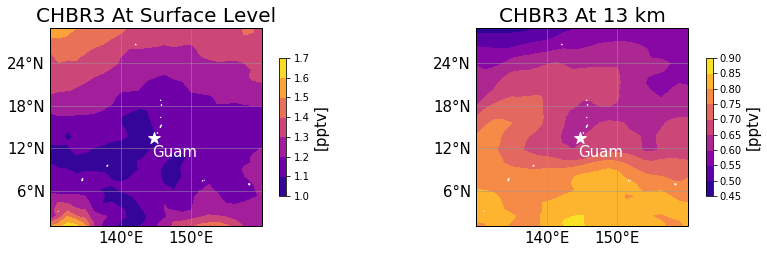

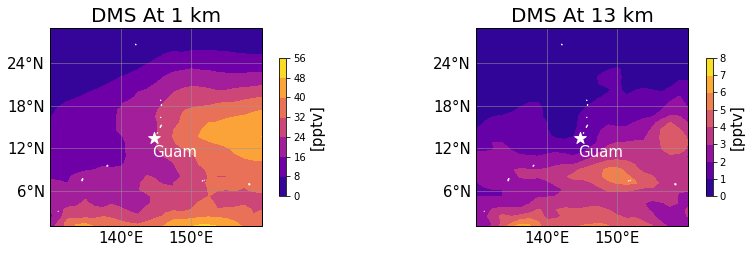

In [89]:
# ------------------------------------------- figure 3 -------------------------------------------
# plot camchem at surface level and at 11 km - CHBR3 
# test plot 
fig = plt.figure(figsize=(14, 8))

# ------------------------- Near Surface 
# surface
surf = find_nearest(km_to_hpa(1), cam['lev'])

# plot 
ax = plt.subplot(2,2,1, projection=ccrs.PlateCarree())
chbr3_surf = cam['CHBR3'].isel(lev = surf).squeeze()
plt.contourf(chbr3_surf.lon, chbr3_surf.lat, chbr3_surf, cmap = 'plasma')
ax.set_title('CHBR3 At Surface Level', fontsize=20)

ax.set_extent([130, 160, 1, 29], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='w', linewidth=1)
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([130, 140, 150, 160, 170, 180])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# get handle of colorbar so we can edit 
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.set_ylabel('[pptv]', fontsize=15)

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'w', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'w', ha="center", va="center", size=15)


# ------------------------- Near UT 
# 10 km
ut = find_nearest(km_to_hpa(13), cam['lev'])

# plot 
ax = plt.subplot(2,2,2, projection=ccrs.PlateCarree())
chbr3_ut = cam['CHBR3'].isel(lev = ut).squeeze()
plt.contourf(chbr3_ut.lon, chbr3_ut.lat, chbr3_ut, cmap = 'plasma')
ax.set_title('CHBR3 At 13 km', fontsize=20)

ax.set_extent([130, 160, 1, 29], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='w', linewidth=1)
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([130, 140, 150, 160, 170, 180])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# get handle of colorbar so we can edit 
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.set_ylabel('[pptv]', fontsize=15)
#cbar.formatter.set_powerlimits((0, 0))
#cbar.update_ticks()

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'w', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'w', ha="center", va="center", size=15)


#### # ------------------------------------------- DMS -------------------------------------------
# plot camchem at surface level and at 11 km - DMS 
# test plot 
fig = plt.figure(figsize=(14, 8))

# ------------------------- Near Surface 
# surface
surf = find_nearest(km_to_hpa(1), cam['lev'])

# plot 
ax = plt.subplot(2,2,3, projection=ccrs.PlateCarree())
DMS_surf = cam['DMS'].isel(lev = surf).squeeze()
plt.contourf(DMS_surf.lon, DMS_surf.lat, DMS_surf, cmap = 'plasma')
ax.set_title('DMS At 1 km', fontsize=20)

ax.set_extent([130, 160, 1, 29], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='w', linewidth=1)
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([130, 140, 150, 160, 170, 180])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# get handle of colorbar so we can edit 
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.set_ylabel('[pptv]', fontsize=15)

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'w', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'w', ha="center", va="center", size=15)


# ------------------------- Near UT 
# 13 km 
ut = find_nearest(km_to_hpa(13), cam['lev'])

# plot 
ax = plt.subplot(2,2,4, projection=ccrs.PlateCarree())
DMS_ut = cam['DMS'].isel(lev = ut).squeeze()
plt.contourf(DMS_ut.lon, DMS_ut.lat, DMS_ut, cmap = 'plasma')
ax.set_title('DMS At 13 km', fontsize=20)

ax.set_extent([130, 160, 1, 29], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='w', linewidth=1)
gg = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='0.6', linestyle='-')
gg.xlocator = mticker.FixedLocator([130, 140, 150, 160, 170, 180])
gg.xlabels_top = False
gg.ylabels_right = False
gg.xformatter = LONGITUDE_FORMATTER
gg.yformatter = LATITUDE_FORMATTER
gg.xlabel_style = {'size': 15, 'color': 'k'}
gg.ylabel_style = {'size': 15, 'color': 'k'}

# get handle of colorbar so we can edit 
cbar = plt.colorbar(shrink = 0.7)
cbar.ax.set_ylabel('[pptv]', fontsize=15)
#cbar.formatter.set_powerlimits((0, 0))
#cbar.update_ticks()

# add guam marker 
plt.scatter(144.7, 13.4, s = 150, c = 'w', marker = '*')
ax.text(144.7+3, 13.4-2, "Guam", c = 'w', ha="center", va="center", size=15)


#### Figure 4
These contour plots show the chemical distribution at 1 km (left) and at 13 km (right) for bromoform (top) and DMS (bottom). For both species, near surface concentrations are significantly higher than UT concentrations. This fits in with what we know about trace gas budgets (both of these are produced near the surface) and convective transport (both of these are transported vertically into the UT via convection). 

### Figure 5: Statistical Comparison of Bromoform in BL and UT 

Text(0.2, 4.2, '2400 CAMchem Samples')

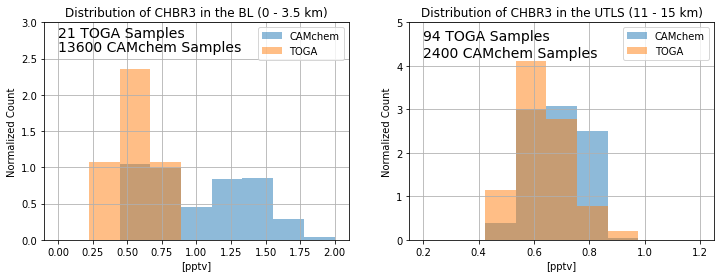

In [90]:
# ------------------------------------------- figure 5 -------------------------------------------
# CHBR3 comparison in boundary layer (BL) and upper troposphere lower stratosphere (UTLS) 

# ------------------------ BL 
# camchem values near surface 
bltop = km_to_hpa(3.5)
cam_chbr3_bl = cam['CHBR3'].sel(lev = slice(bltop,1000)).values.flatten()
# toga values near surface
toga_chbr3_bl = toga.Bromoform[np.where(toga.GGALT < 3500)]

# plot 
fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

bins = np.linspace(0, 2, 10)
ax[0].hist(cam_chbr3_bl, bins, alpha=0.5, density = True, label = 'CAMchem')
ax[0].hist(toga_chbr3_bl, bins, alpha=0.5, density = True, label = 'TOGA')

ax[0].grid(which = 'major')
ax[0].set_title ('Distribution of CHBR3 in the BL (0 - 3.5 km)')
ax[0].set_xlabel('[pptv]')
ax[0].set_ylabel('Normalized Count')
ax[0].legend()

ax[0].set_ylim(0, 3)

# annotate 
ax[0].annotate(str(np.shape(np.where(toga_chbr3_bl > 0))[1])+' TOGA Samples', xy=(0, 2.8), 
              fontsize = 14)
ax[0].annotate(str(len(cam_chbr3_bl))+' CAMchem Samples', xy=(0, 2.6), 
              fontsize = 14)

# ------------------------ UT
uttop = km_to_hpa(15)
utbottom = km_to_hpa(11)
# camchem values in upper tropo 
cam_chbr3_ut = cam['CHBR3'].sel(lev = slice(uttop,utbottom)).values.flatten()
# toga values near surface
toga_chbr3_ut = toga.Bromoform[np.where(toga.GGALT > 11000)]

# plot 
bins = np.linspace(0.2, 1.2, 10)
ax[1].hist(cam_chbr3_ut, bins, alpha=0.5, density = True, label = 'CAMchem')
ax[1].hist(toga_chbr3_ut, bins, alpha=0.5, density = True, label = 'TOGA')

ax[1].grid(which = 'major')
ax[1].set_title ('Distribution of CHBR3 in the UTLS (11 - 15 km)')
ax[1].set_xlabel('[pptv]')
ax[1].set_ylabel('Normalized Count')
ax[1].legend()

ax[1].set_ylim(0, 5)

# annotate 
ax[1].annotate(str(np.shape(np.where(toga_chbr3_ut > 0))[1])+' TOGA Samples', xy=(0.2, 4.6), 
              fontsize = 14)
ax[1].annotate(str(len(cam_chbr3_ut))+' CAMchem Samples', xy=(0.2, 4.2), 
              fontsize = 14)

#### Figure 5
Here is a comparison in the distribution of all samples within the 0-3.5 km (BL, left) and 11-15 km (UT, right) height ranges for bromoform. Normalization is applied to allow for easier visual comparison of the two despite their vastly different sample counts. This vast difference in sampling counts is due to the nature of the data collection - CAMchem is a GCM so has models in all of 3D space, while the aircraft data is sparse along the flight track. 

CAMchem has higher concentrations in the BL, but much better agreement in the UT. This might be due to issues with the model's boundary conditions and/or the very limited sampling by the TOGA instrument. 

### Figure 6: Statistical Comparison of DMS in BL and UT 

Text(0, 0.63, '2400 CAMchem Samples')

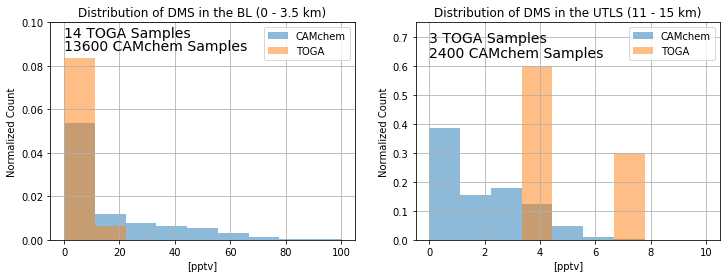

In [91]:
# ------------------------------------------- figure 6 -------------------------------------------
# DMS comparison in boundary layer (BL) and upper troposphere lower stratosphere (UTLS) 

# ------------------------ BL 
# camchem values near surface 
cam_dms_bl = cam['DMS'].sel(lev = slice(bltop,1000)).values.flatten()
# toga values near surface
toga_dms_bl = toga.DMS[np.where(toga.GGALT < 3500)]

# plot 
fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

bins = np.linspace(0, 100, 10)
ax[0].hist(cam_dms_bl, bins, alpha=0.5, density = True, label = 'CAMchem')
ax[0].hist(toga_dms_bl, bins, alpha=0.5, density = True, label = 'TOGA')

ax[0].grid(which = 'major')
ax[0].set_title ('Distribution of DMS in the BL (0 - 3.5 km)')
ax[0].set_xlabel('[pptv]')
ax[0].set_ylabel('Normalized Count')
ax[0].legend()

ax[0].set_ylim(0, 0.1)

# annotate
ax[0].annotate(str(np.shape(np.where(toga_dms_bl > 0))[1])+' TOGA Samples', xy=(0, 0.093), 
              fontsize = 14)
ax[0].annotate(str(len(cam_dms_bl))+' CAMchem Samples', xy=(0, 0.087), 
              fontsize = 14)

# ------------------------ UT
uttop = km_to_hpa(15)
utbottom = km_to_hpa(11)
# camchem values in upper tropo 
cam_dms_ut = cam['DMS'].sel(lev = slice(uttop,utbottom)).values.flatten()
# toga values near surface
toga_dms_ut = toga.DMS[np.where(toga.GGALT > 11000)]

# plot 
bins = np.linspace(0, 10, 10)
ax[1].hist(cam_dms_ut, bins, alpha=0.5, density = True, label = 'CAMchem')
ax[1].hist(toga_dms_ut, bins, alpha=0.5, density = True, label = 'TOGA')

ax[1].grid(which = 'major')
ax[1].set_title ('Distribution of DMS in the UTLS (11 - 15 km)')
ax[1].set_xlabel('[pptv]')
ax[1].set_ylabel('Normalized Count')
ax[1].legend()

ax[1].set_ylim(0, 0.75)

# annotate 
ax[1].annotate(str(np.shape(np.where(toga_dms_ut > 0))[1])+' TOGA Samples', xy=(0, 0.68), 
              fontsize = 14)
ax[1].annotate(str(len(cam_dms_ut))+' CAMchem Samples', xy=(0, 0.63), 
              fontsize = 14)


#### Figure 6
Similarly to above, this figure shows a comparison in the distribution of all samples within the 0-3.5 km (BL, left) and 11-15 km (UT, right) height ranges for DMS. 

CAMchem has major discrepancies in the BL, with some values upwards of 100 pptv. All observed DMS data is 0-20 pptv. There is not good agreement in the UT either. This could be for reasons explained above, but also is related to the skewed sampling and limitations of the chemical detection instruments. DMS samples in the UT are only captured near strong convective updrafts and so is very rarely sampled at all. We only see 3 values above detection limit! 

### Figure 7: Rough Point to Point Comparison, DMS 

In [92]:
# ------------------------------------------- figure 7 -------------------------------------------
# isolate each toga point lat and lon 
toga_time = []
time_steps = []
for i in range(0, len(toga.Time)):
    if (np.isnan(toga.GGALT.values[i]) == False):
        toga_time.append(toga.Time[i])
        time_steps.append(i)
        
# match each toga point to a camchem profile (1 x 56 levels)
cam_dms_points = np.zeros((len(time_steps), len(cam.lev)))
cam_chbr3_points = np.zeros((len(time_steps), len(cam.lev)))

for i in range(0, len(toga.Time)):
    if (np.isnan(toga.GGALT.values[i]) == False):
        cam_dms_points[i,:] = cam['DMS'].sel(lat = toga.GGLAT.values[i], method='nearest').sel(lon = toga.GGLON.values[i], method='nearest')
        cam_chbr3_points[i,:] = cam['CHBR3'].sel(lat = toga.GGLAT.values[i], method='nearest').sel(lon = toga.GGLON.values[i], method='nearest')
        

In [93]:
# convert toga height in meters to pressure 
toga_hpa = []
for i in toga.GGALT[:-3].values:
    toga_hpa.append(((1000*100)*np.exp(-i/(10*1000)))/100)

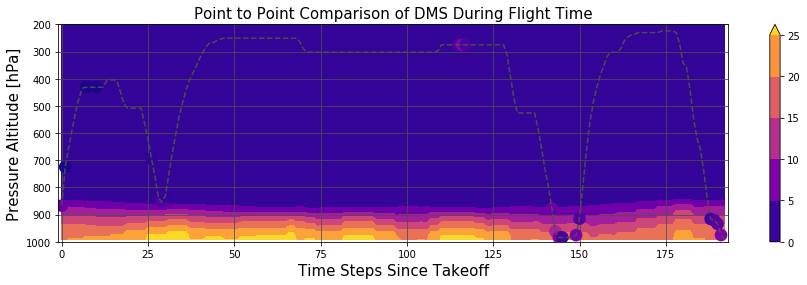

In [94]:
# plot camchem - CHBR3
fig, ax = plt.subplots(figsize=(15, 4))

# limits of colorbar
cminn = 0
cmaxx = 30

# contour
p0 = ax.contourf(time_steps, cam.lev, np.transpose(cam_dms_points), cmap = 'plasma')
plt.xlabel('Time Steps Since Takeoff', fontsize=15)
plt.ylabel('Pressure Altitude [hPa]', fontsize=15)
plt.title('Point to Point Comparison of DMS During Flight Time', fontsize=15)
plt.grid(which='major', linestyle='-', color = '0.3')

ax.set_ylim([1000, 200])
ax.set_xlim([-1, len(time_steps)])

# only toga not fill value 


# add toga to plot 
ax.plot(time_steps, toga_hpa, linestyle = '--', color = '0.3', zorder = 3)
ax.scatter(time_steps, toga_hpa, c = toga.DMS[:-3], cmap = 'plasma',
            vmin = cminn, vmax = cmaxx, marker='o', s=75, linewidths=4, zorder = 2)

# colorbar
m = plt.cm.ScalarMappable(cmap='plasma')
m.set_array(cam_dms_points)
m.set_clim(cminn, cmaxx)
plt.colorbar(m, boundaries=np.arange(cminn, cmaxx+5, 5), extend = 'max')

#### Figure 7
This figure pulls the CAMchem profile nearest to each aircraft sampling point, and stitches them together in order. This way we can compare the aircraft data directly to the CAMchem output at every latitude/longitude combination. 

As discussed previously, DMS has a pretty poor comparison. The few sampled points in the UT do not agree well with the model. In the boundary layer the modeled DMS concentrations are significantly higher than any observation. 

### Figure 8: Rough Point to Point Comparison, Bromoform

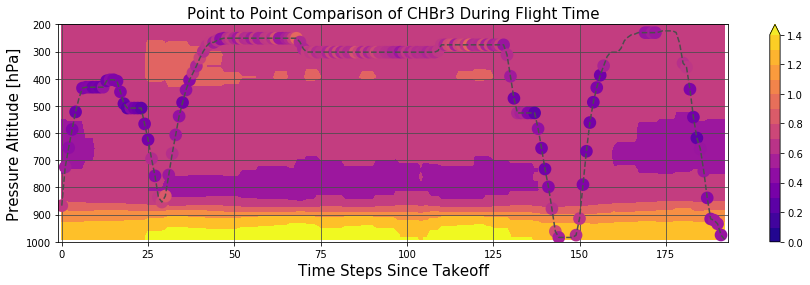

In [95]:
# plot camchem - CHBR3
fig, ax = plt.subplots(figsize=(15, 4))

# limits of colorbar
cminn = 0
cmaxx = 1.5

# contour
p0 = ax.contourf(time_steps, cam.lev, np.transpose(cam_chbr3_points), cmap = 'plasma', 
           vmin = cminn, vmax = cmaxx)
plt.xlabel('Time Steps Since Takeoff', fontsize=15)
plt.ylabel('Pressure Altitude [hPa]', fontsize=15)
plt.title('Point to Point Comparison of CHBr3 During Flight Time', fontsize=15)
plt.grid(which='major', linestyle='-', color = '0.3')

ax.set_ylim([1000, 200])
ax.set_xlim([-1, len(time_steps)])

# add toga 
ax.plot(time_steps, toga_hpa, linestyle = '--', color = '0.3', zorder = 3)
ax.scatter(time_steps, toga_hpa, c = toga.Bromoform[:-3], cmap = 'plasma',
            vmin = cminn, vmax = cmaxx, marker='o', s=75, linewidths=4, zorder = 2)

# colorbar
m = plt.cm.ScalarMappable(cmap='plasma')
m.set_array(cam_chbr3_points)
m.set_clim(cminn, cmaxx)
plt.colorbar(m, boundaries=np.arange(cminn, cmaxx+0.1, 0.1), extend = 'max')

#### Figure 8
This figure is similar to the one above, but shows the comparison for bromoform. There is a pretty stark discrepancy in the BL but the UT samples seem to be in pretty good agreement. 

## Some Concusions 

There is decent agreement between the modeled and observed data in terms of general and relative distribution (i.e. maximum concentration near the surface, diminishing out of the boundary layer) but some pretty large discrepancies in magnitude. CAMchem consistently shows mixing ratios much higher than observed by the flight data. 

Bromoform has a much better agreement than DMS. Overall bromoform's distribution is fairly comprable between the two data sets, With the largest difference being in the scale of boundary layer concentrations. This is likely due to the model's boundary layer conditions which may not estimate surface fluxes properly. 

DMS does not have great agreement. The surface values are vastly different, with outliers >100 ppt for CAMchem. Maximum observed values are all < 20 ppt. 

The DMS enhacements in the UT observations are not present in the model. This is likely due to the extremely short lifetime of DMS (~1 day) and the model struggling to properly represent its transport via strong convective updrafts. These features are parameterized rather than explicityly resolved, and so chemical transport via these pathways is typically not well represented in GCMs. This mostly affects very short lived species such as DMS. Also, detection limits of the trace gas prohibit very low mixing ratio samples skewing the UT distribution of observed samples. 

Some caveats to this simple analysis are: 

1) We are only using one day of flight data, which is far too small a dataset to truly compare the two. For example, our histograms are only ~20 - 100 TOGA samples vs. thousands of CAMchem samples. Ideally this would be a lot more robust using a lot more data than just one flight. 

2) The point to point comparison is only a simple nearest-point analysis. Ideally, the two data sets would be interpolated. 